In [1]:
from chebGreen import ChebGreen
import numpy as np
import matplotlib.pyplot as plt

from chebGreen.chebpy2 import Quasimatrix
from chebGreen.chebpy2.chebpy import chebfun
from chebGreen.chebpy2 import Chebfun2

# %env TF_MLC_LOGGING=1
# %env TF_CPP_MIN_LOG_LEVEL=2

In [2]:
airy = ChebGreen([1,5,10], generateData = True, script = "generate_example", example = "airy_equation")

Generating dataset for example 'airy_equation'
Dataset found for Theta = 1.00. Skipping dataset generation.
Dataset found for Theta = 5.00. Skipping dataset generation.
Dataset found for Theta = 10.00. Skipping dataset generation.
-------------------------------------------------------------------------------

Generating chebfun2 models:
Found saved model, Loading model for example 'airy_equation' at Theta = 1.00
Learning a chebfun2 model for example 'airy_equation' at Theta = 1.00
Chebfun2 model added for example 'airy_equation' at Theta = 1.00

Found saved model, Loading model for example 'airy_equation' at Theta = 5.00
Learning a chebfun2 model for example 'airy_equation' at Theta = 5.00
Chebfun2 model added for example 'airy_equation' at Theta = 5.00

Found saved model, Loading model for example 'airy_equation' at Theta = 10.00
Learning a chebfun2 model for example 'airy_equation' at Theta = 10.00
Chebfun2 model added for example 'airy_equation' at Theta = 10.00



In [3]:
airy.G

{1.0: chebfun2 object
      domain       rank               corner values
 [0,1] x [0,1]     59       [-0.000 -0.000 -0.000 -0.000]
 vertical scale = 0.238198,
 5.0: chebfun2 object
      domain       rank               corner values
 [0,1] x [0,1]     59       [-0.000 -0.000 -0.000 -0.000]
 vertical scale = 0.138575,
 10.0: chebfun2 object
      domain       rank               corner values
 [0,1] x [0,1]     59       [0.000 -0.000 -0.000 -0.000]
 vertical scale = 0.087169}

Text(0, 0.5, 's')

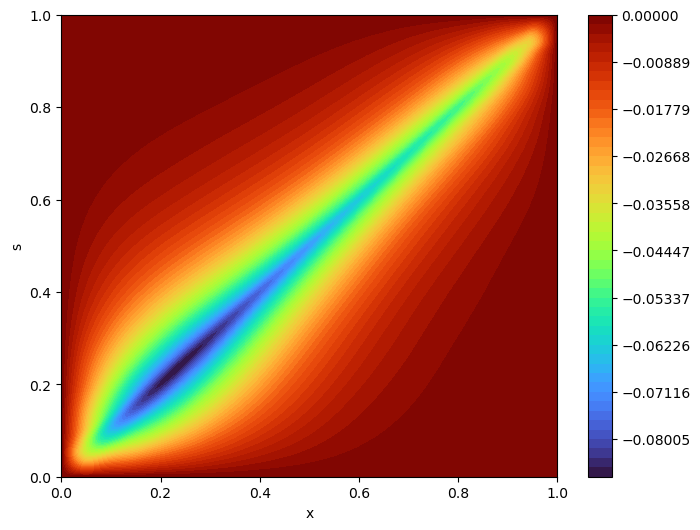

In [4]:
fig = plt.figure(figsize = (8,6))
airy.G[10].plot(fig = fig, ax = plt.gca())
plt.xlabel('x')
plt.ylabel('s')

In [5]:
%%time
u,s,v = airy.G[1].svd()

CPU times: user 5.25 s, sys: 5.93 s, total: 11.2 s
Wall time: 1.77 s


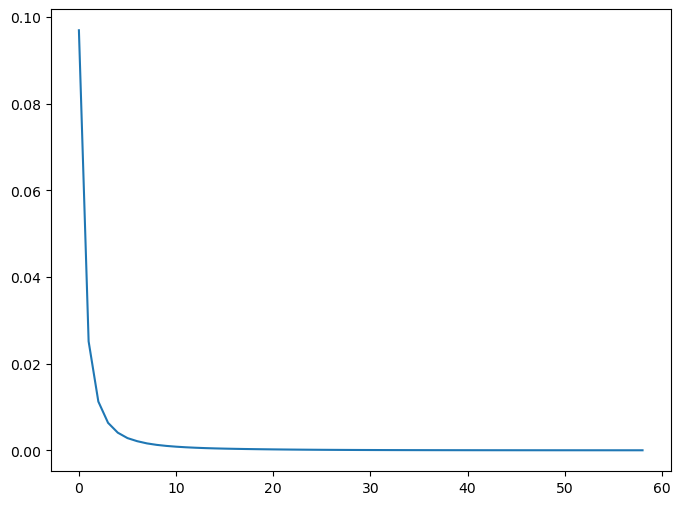

In [6]:
fig = plt.figure(figsize = (8,6))
plt.plot(s)

(0.0, 1.0)

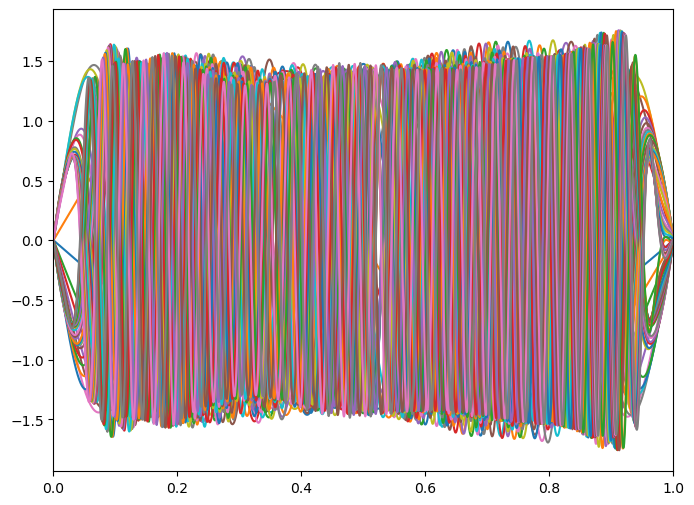

In [7]:
# i = slice(10,20)
i = slice(0,-1)
# i = 16
fig = plt.figure(figsize = (8,6))
u[:,i].plot(fig = fig)
# print(np.max(u[:,i].vscale))
# plt.title(f'First {i+1} left singular functions for a Laplacian')
plt.xlim([0,1])
# fig.savefig(f'Laplace-first.png', dpi = fig.dpi)

In [8]:
%%time
theta_ = 7.0
G7 = airy.generateNewModel(theta_)

CPU times: user 25.9 s, sys: 28.2 s, total: 54.1 s
Wall time: 8.7 s


In [9]:
validation = ChebGreen([7], generateData = True, script = "generate_example", example = "airy_equation")

Generating dataset for example 'airy_equation'
Dataset found for Theta = 7.00. Skipping dataset generation.
-------------------------------------------------------------------------------

Generating chebfun2 models:
Found saved model, Loading model for example 'airy_equation' at Theta = 7.00
Learning a chebfun2 model for example 'airy_equation' at Theta = 7.00
Chebfun2 model added for example 'airy_equation' at Theta = 7.00



In [10]:
xx = np.linspace(0,1,2000)
yy = np.linspace(0,1,2000)
x, y = np.meshgrid(xx,yy)

-0.11172064195056348


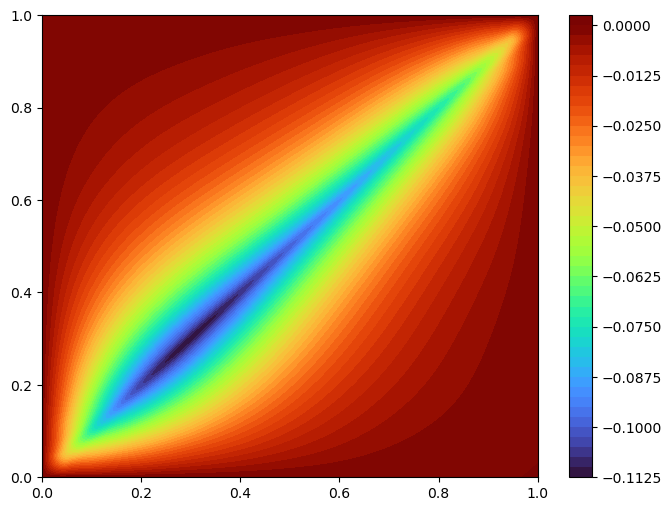

In [11]:
G = (validation.G[7])[x,y]
fig = plt.figure(figsize = (8,6))
vmin, vmax = np.min(G), np.max(G)
plt.contourf(x,y,G, 50, cmap = 'turbo', vmin = vmin, vmax = vmax)
plt.colorbar()
print(np.min(G))
# fig.savefig(f'poisson_greenlearning_chebfun2.png', dpi = fig.dpi)

-0.10868631154676421


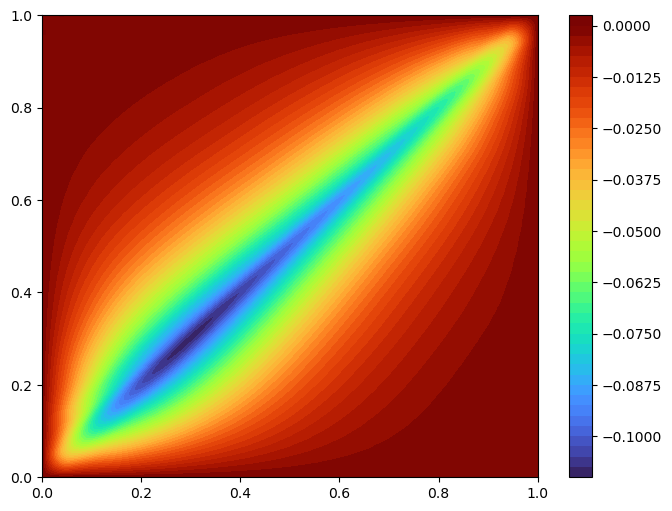

In [12]:
G = G7[x,y]
fig = plt.figure(figsize = (8,6))
# vmin, vmax = np.min(G), np.max(G)
plt.contourf(x,y,G, 50, cmap = 'turbo', vmin = vmin, vmax = vmax)
plt.colorbar()
print(np.min(G))
# fig.savefig(f'poisson_greenlearning_chebfun2.png', dpi = fig.dpi)